In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

import theano.tensor as tt

from pymc3 import Model, sample, Metropolis, advi, Deterministic
from pymc3.distributions import *

In [2]:
weight_change = pd.read_csv('../data/clean/weight_change_year.csv', index_col=0)
weight_change.head()

,6389688,6463681,7311533,8548844,9285487,9729856,9852930,10964583,11158425,11167376,...,37415510,37656279,37820214,38027298,38098992,38167110,38187332,38524377,39248562,39855721
Days,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000,0.00,0.0,NaN,0.00,0.0,0.0,0.0,...,0.0000,0.00,0.0,0.0,0.000,0.00,0.000000,0.000,NaN,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0.98,NaN,4.7,NaN,...,1.1375,NaN,NaN,NaN,1.720,NaN,NaN,-0.170,NaN,NaN
2,NaN,NaN,NaN,-4.71,NaN,NaN,-3.63,NaN,12.7,NaN,...,2.4000,-0.32,NaN,NaN,1.175,-4.50,NaN,2.210,NaN,NaN
3,NaN,NaN,8.975,-7.43,NaN,NaN,-6.73,NaN,14.3,NaN,...,5.7100,NaN,NaN,NaN,2.040,-6.09,0.030000,6.175,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,-6.67,NaN,10.1,NaN,...,5.6200,NaN,NaN,NaN,4.260,-5.69,1.173333,9.720,NaN,NaN


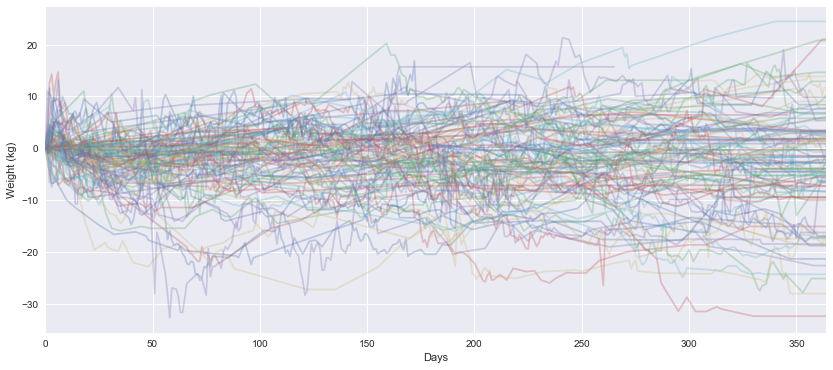

In [3]:
fig, axes = plt.subplots(figsize=(14,6))
(weight_change.interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

Stick-breaking function for Dirichlet process

In [4]:
def stick_breaking(beta):
    
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

Maximum number of groups

In [5]:
K = 10
D, N = weight_change.shape

In [7]:
with Model() as model:
    
    α = Gamma('α', 1., 1.)
    β = Beta('β', 1., α, shape=K)
    ω = Deterministic('ω', stick_breaking(β))
    
    z = Categorical('z', ω, shape=N)
    
#     for i in range(K):

In [8]:
z.tag.test_value

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])